In [1]:
# ! pip install --upgrade ultralytics 
# !pip install --upgrade -U ray[tune]

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- Label Annotation: YOLO format (.txt)
     - `[class_id, center_x, center_y, width, height]`
      
___      

In [1]:
! tree ../data/Module_4_Lecture_1_Construction_Site_Safety -L 2

../data/Module_4_Lecture_1_Construction_Site_Safety
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   ├── labels
│   └── labels.cache
└── valid
    ├── images
    ├── labels
    └── labels.cache

9 directories, 2 files


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

%matplotlib inline

! wandb disabled

W&B disabled.


In [19]:
class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8
    
    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '../data/Module_4_Lecture_1_Construction_Site_Safety/'
    OUTPUT_DIR = '../'

Create ```data.yaml``` file properly formatted to be used by Yolo

In [4]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [5]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: ../data/Module_4_Lecture_1_Construction_Site_Safety/test
train: ../data/Module_4_Lecture_1_Construction_Site_Safety/train
val: ../data/Module_4_Lecture_1_Construction_Site_Safety/valid



Visualize one image

In [6]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



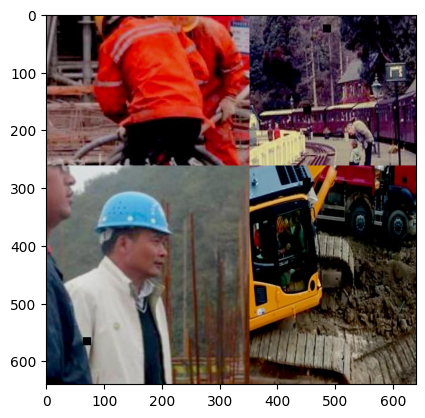

In [7]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

Visualize many images

In [8]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

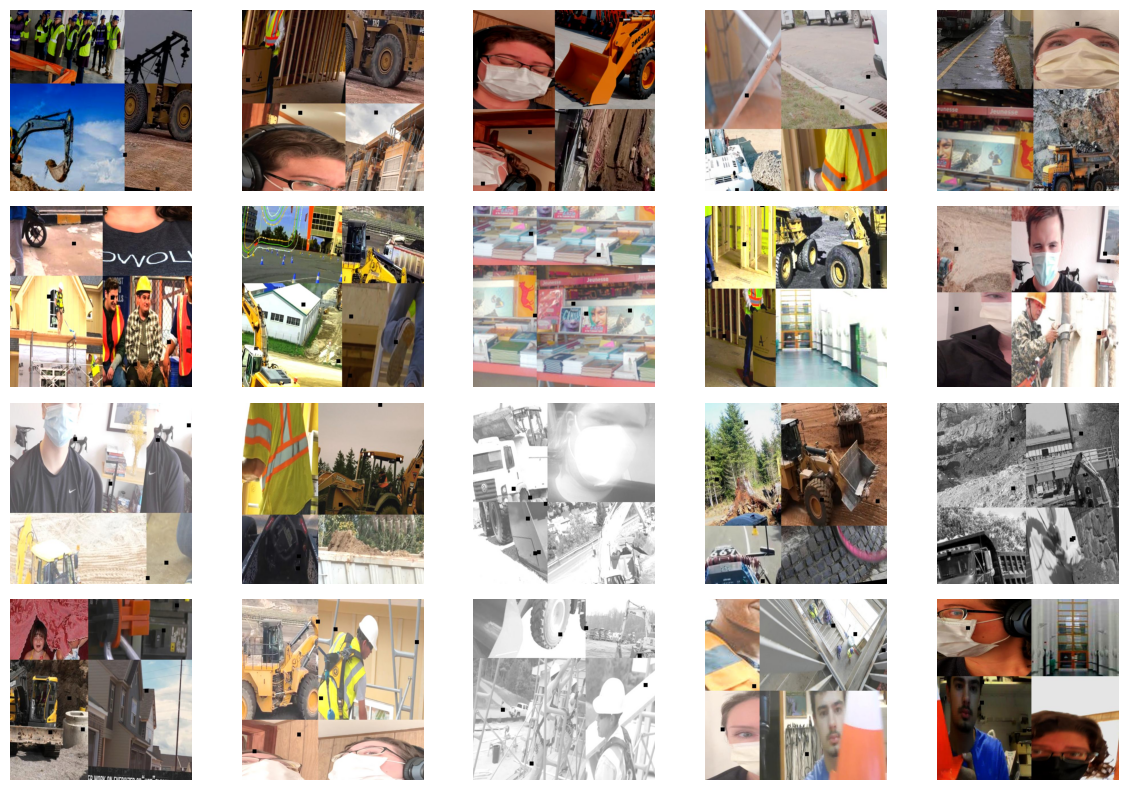

In [9]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

Image properties

In [10]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [11]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Dataset statistics

In [12]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None): 
    display(dataset_stats_df)


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


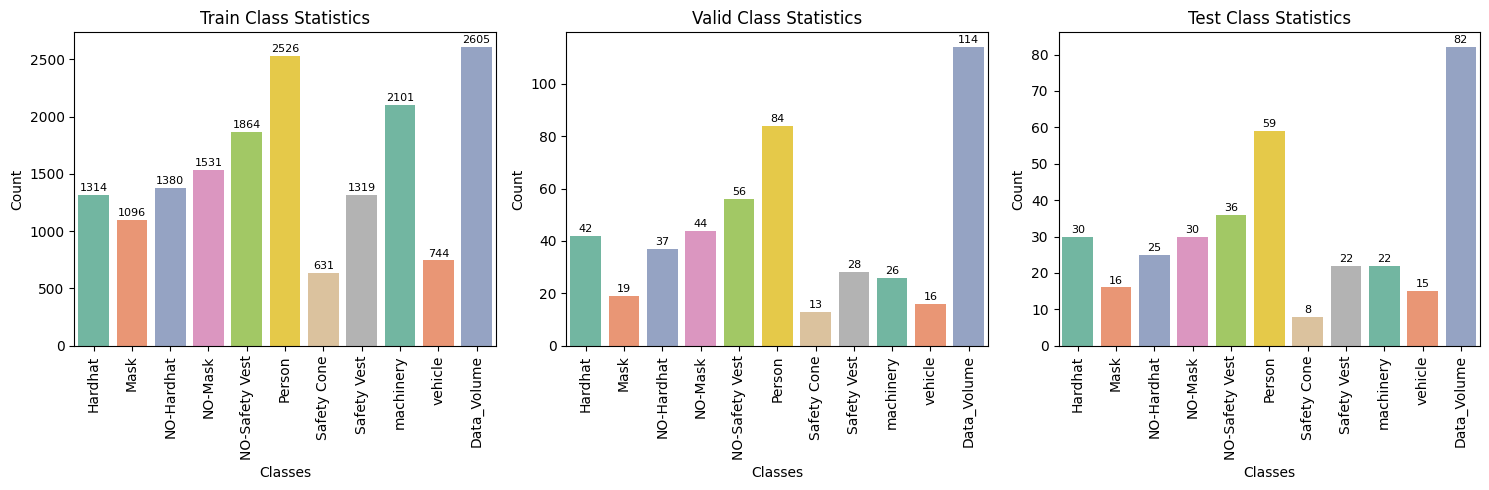

In [13]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Base Model Inference

Checking the power of the pretrained model inference on the CSS dataset

In [14]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|████████████████████████████████████████| 112M/112M [00:03<00:00, 32.6MB/s]



image 1/1 /home/barmalejka/data/GoIT/notebooks/../data/Module_4_Lecture_1_Construction_Site_Safety/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 8 persons, 2925.8ms
Speed: 1.8ms preprocess, 2925.8ms inference, 66.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



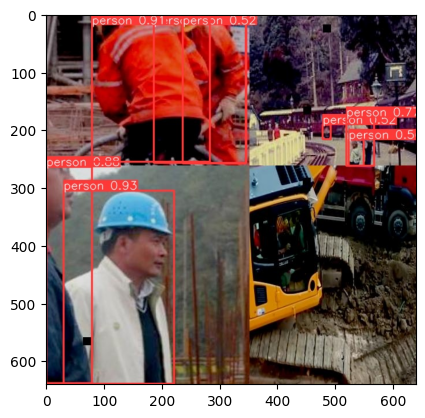

In [15]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [16]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  8


In [17]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

**IMPORTANT**<br>
Modify `/home/user/.config/Ultralytics/settings.yaml` file so that there is no errors loading the data


In [ ]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1] 
#     device = None, # CPU run
    verbose = False,
)

New https://pypi.org/project/ultralytics/8.2.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.25 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /home/barmalejka/data/GoIT/data/Module_4_Lecture_1_Construction_

train: WARNING ⚠️ /home/barmalejka/data/GoIT/data/Module_4_Lecture_1_Construction_Site_Safety/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/barmalejka/data/GoIT/data/Module_4_Lecture_1_Construction_Site_Safety/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /home/barmalejka/data/GoIT/data/Module_4_Lecture_1_Construction_Site_Safety/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/barmalejka/data/GoIT/data/Module_4_Lecture_1_Construction_Si

Plotting labels to runs/detect/yolov8n_ppe_css_70_epochs/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70         0G      1.408      3.187      1.509        356        640:  

[Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv9 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Train results

In [20]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['../runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 '../runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 '../runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

../runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


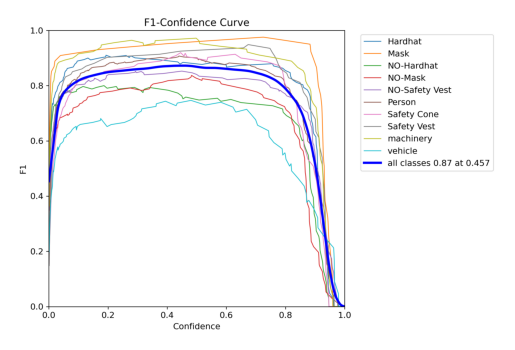



../runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


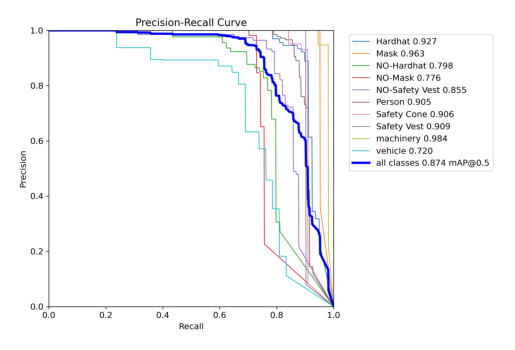



../runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


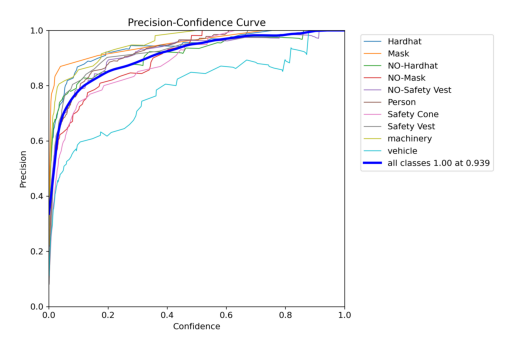



../runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


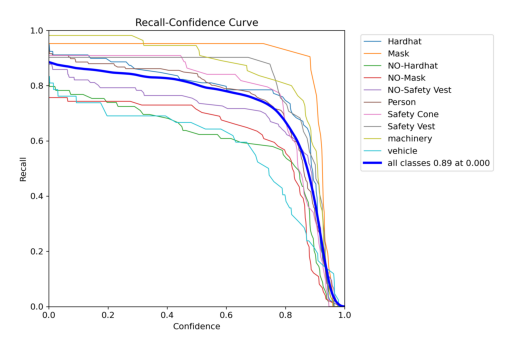



../runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


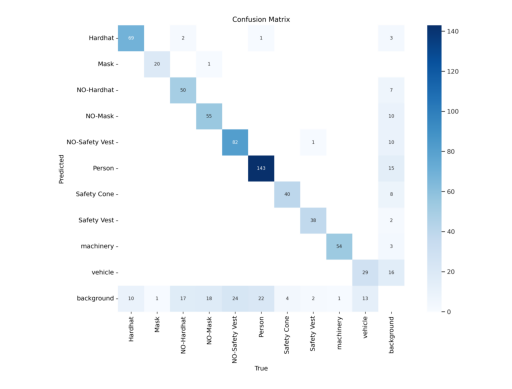



../runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


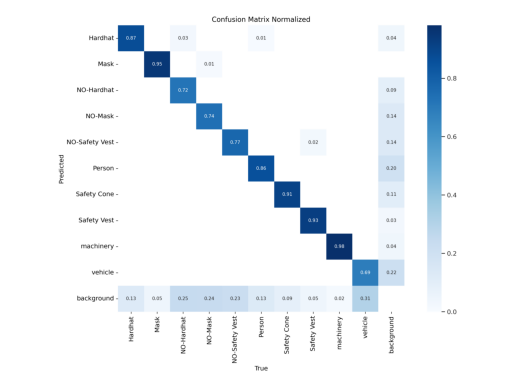



../runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


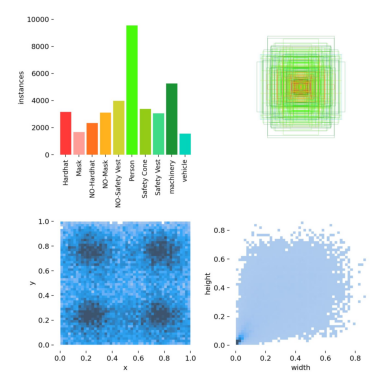



../runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


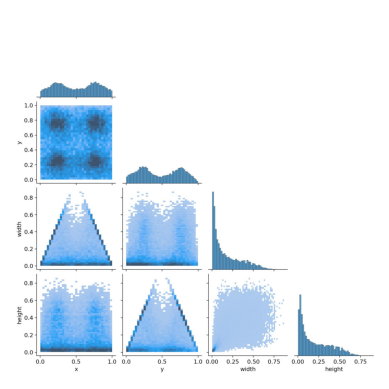



../runs/detect/yolov9e_ppe_css_70_epochs/results.png


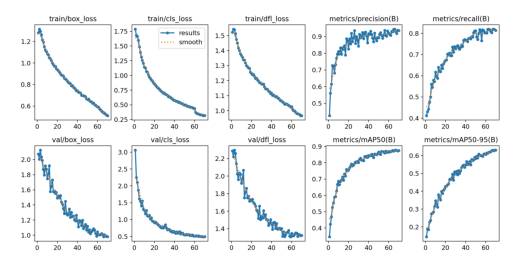

In [21]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

Loss

- The loss function in YOLO consists of three main components: box loss, class loss (cls loss), and objectness loss (dfl loss).
- The total loss in YOLO is a combination of these three components

___

**Box loss:**
- The box loss measures how accurately the predicted bounding box coordinates match the ground truth bounding box.
- Is typically computed using a regression loss, such as Mean Squared Error (MSE), between the predicted bounding box coordinates (center coordinates, width, and height) and the ground truth bounding box coordinates.

___

**Class loss (cls):**
- The class loss measures how well the predicted class probabilities match the true class labels.
- The class loss is usually computed using a categorical cross-entropy loss, which penalizes the difference between the predicted class probabilities and the true class labels.

___

**Objectness loss (dfl):**
- Distribution Focal Loss
- YOLO predicts an "objectness" score for each bounding box, indicating the presence of an object within the grid cell. This score helps filter out irrelevant bounding boxes.
- The objectness loss is calculated based on the difference between the predicted objectness score and the ground truth objectness label. It penalizes the model for false positives and false negatives in predicting the presence of an object.

In [22]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.27930,1.78910,1.52160,0.42619,0.41172,0.34588,0.14443,2.07310,3.06080,2.2872,0.000237,0.000237,0.000237
1,2,1.31510,1.68040,1.54360,0.56078,0.43059,0.42255,0.18717,2.00520,2.25030,2.2207,0.000469,0.000469,0.000469
2,3,1.29580,1.66420,1.53940,0.61574,0.44205,0.46838,0.18461,2.12610,2.10160,2.2968,0.000693,0.000693,0.000693
3,4,1.26290,1.59870,1.51220,0.72686,0.47566,0.52597,0.22711,2.03600,1.87420,2.2601,0.000684,0.000684,0.000684
4,5,1.21540,1.48800,1.47540,0.72228,0.49954,0.55366,0.23722,1.98760,1.61680,2.1396,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,0.53865,0.33135,0.97984,0.94469,0.80357,0.87636,0.62954,0.97919,0.50038,1.3107,0.000058,0.000058,0.000058
66,67,0.53204,0.32914,0.97770,0.93025,0.81863,0.87776,0.63008,1.00470,0.49084,1.3363,0.000048,0.000048,0.000048
67,68,0.52592,0.32216,0.97507,0.91772,0.82037,0.87535,0.62793,0.99217,0.49290,1.3296,0.000037,0.000037,0.000037
68,69,0.51559,0.31544,0.96685,0.93799,0.81699,0.87237,0.63125,0.98317,0.48973,1.3211,0.000027,0.000027,0.000027


In [23]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.51023 , on epoch:  70 


Best Validation Box loss:  0.97919 , on epoch:  66 


Best Training Cls loss:  0.31544 , on epoch:  69 


Best Validation Cls loss:  0.48973 , on epoch:  69 


Best Training DFL loss:  0.96685 , on epoch:  69 


Best Validation DFL loss:  1.3076 , on epoch:  59 



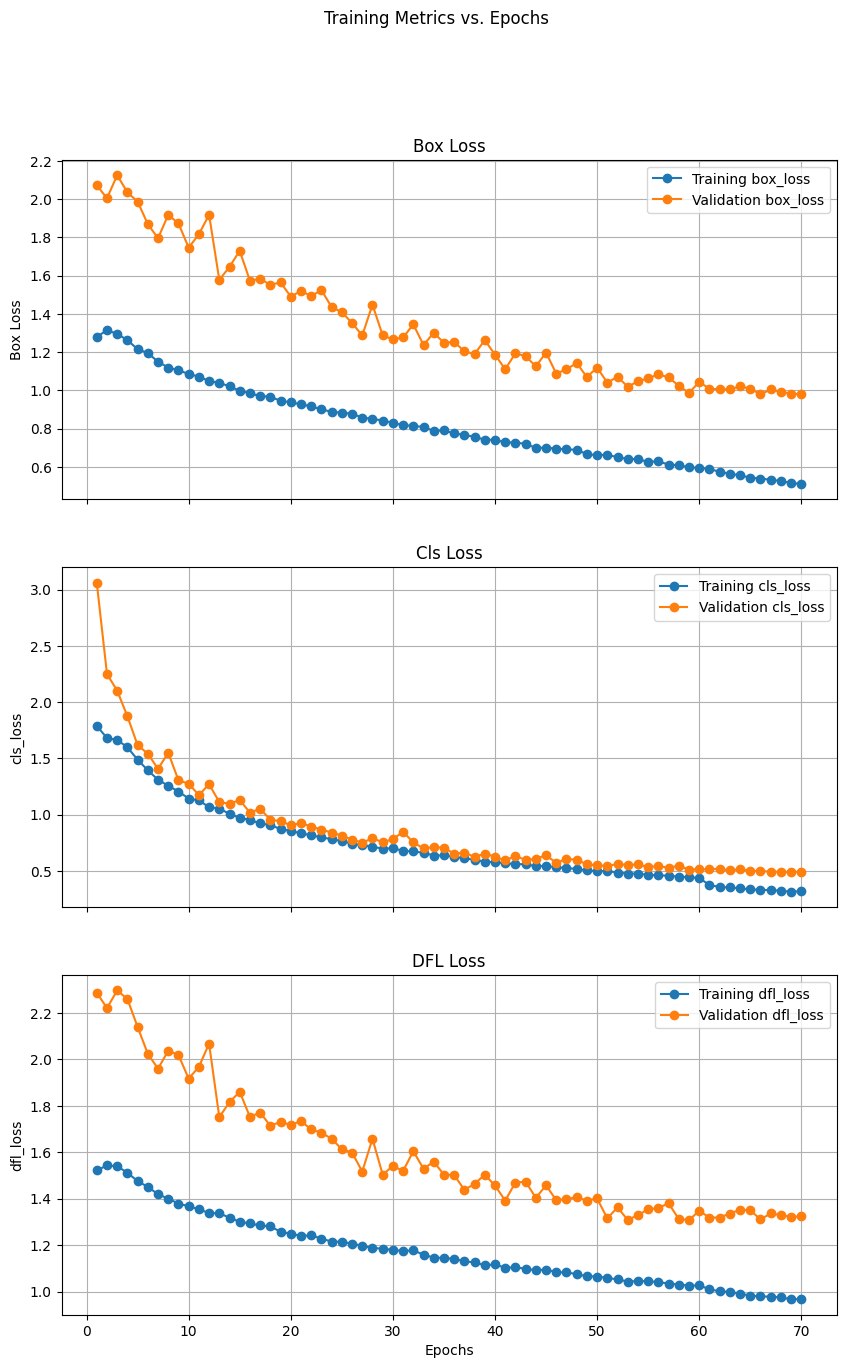

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

Validation results

In [26]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [27]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

../runs/detect/yolov9e_ppe_css_70_epochs/val_batch0_pred.jpg


../runs/detect/yolov9e_ppe_css_70_epochs/val_batch2_labels.jpg


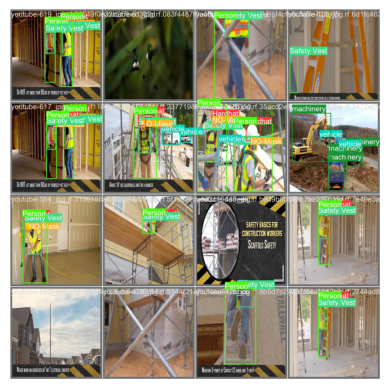

In [28]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)